# Forecast class
This class deals with weather forecasts and uses CLIMADA Impact.calc() to forecast impacts of weather events on society. It mainly does one thing:
- it contains all plotting and other functionality that are specific for weather forecasts and warnings

The class is different from the Impact class especially because features of the Impact class like Exceedence frequency curves, annual average impact etc, do not make sense if the hazard is e.g. a 5 day weather forecast.

## Example: forecast of building damages due to wind in Switzerland
Before using the forecast class, hazard, exposure and vulnerability need to be created. The hazard looks at the weather forecast from today for an event with two days lead time (meaning the day after tomorrow). generate_WS_forecast_hazard is used to download a current weather forecast for wind gust from opendata.dwd.de. An Impact funtion for building damages due to storms is created. And with only a few lines of code, a LitPop exposure for Switzerland is generated,  and the impact is calculated with a default impact function. With a further line of code, the mean damage per grid point for the day after tomorrow is plotted on a map.

In [1]:
from climada.util.config import CONFIG
from climada.engine.forecast import Forecast
from climada.hazard.storm_europe import StormEurope, generate_WS_forecast_hazard
from climada.entity.impact_funcs.storm_europe import IFStormEurope
from climada.entity import ImpactFuncSet
from climada.entity.exposures.litpop import LitPop

#generate hazard
hazard, haz_model, run_datetime, event_date = generate_WS_forecast_hazard()

#generate vulnerability
impact_function = IFStormEurope()
impact_function.set_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_function)

#generate exposure and save to file
filename_exp = CONFIG.local_data.save_dir.dir() / ('exp_' + 
                                               'litpop' +
                                               '_' +
                                               'Switzerland' +
                                               '.hdf5')
if filename_exp.exists():
    exposure = LitPop()
    exposure.read_hdf5(filename_exp)
else:
    exposure = LitPop()
    exposure.set_country('Switzerland', reference_year=2020)
    exposure.write_hdf5(filename_exp)

#create and calculate Forecast
CH_WS_forecast = Forecast({run_datetime: hazard}, exposure, impact_function_set)
CH_WS_forecast.calc()

2021-03-24 17:53:27,543 - climada.hazard.storm_europe - INFO - Generating IEE hazard.
2021-03-24 17:53:27,558 - climada.util.dwd_icon_loader - INFO - Downloading icon grib files of model icon-eu-eps for parameter vmax_10m with starting date 2021032400.
2021-03-24 17:53:27,574 - climada.hazard.storm_europe - INFO - Constructing centroids from C:\Users\ThomasRoosli\climada\data\results\icon_grid_0028_R02B07_N02.nc
2021-03-24 17:53:27,659 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


C:\shortpaths\GitHub\climada_python\climada\hazard\centroids\centr.py:624: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no lat

2021-03-24 17:54:39,285 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 17:54:39,285 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 17:54:39,285 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 17:54:39,285 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 17:54:39,292 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-24 17:54:39,308 - climada.entity.exposures.base - INFO - Reading C:\Users\ThomasRoosli\climada\data\results\exp_litpop_Switzerland.hdf5
2021-03-24 17:54:39,386 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 17:54:39,386 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 17:54:39,386 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 17:54:39,386 - climada.entity

C:\shortpaths\GitHub\climada_python\climada\entity\exposures\base.py:219: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


2021-03-24 17:54:41,445 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 40 events.
2021-03-24 17:54:41,445 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_WS. Using impact functions in if_.


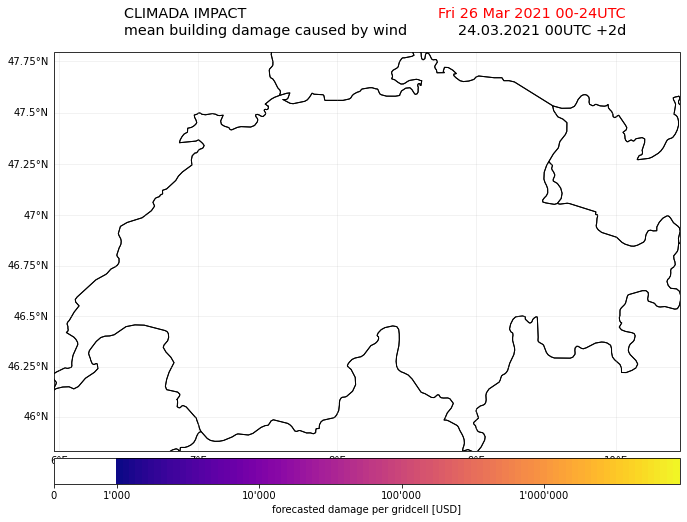

In [2]:
CH_WS_forecast.plot_imp_map(save_fig=False,close_fig=False)

Here you see a different plot highlighting the spread of the impact forecast calculated from the different ensemble members of the weather forecast.

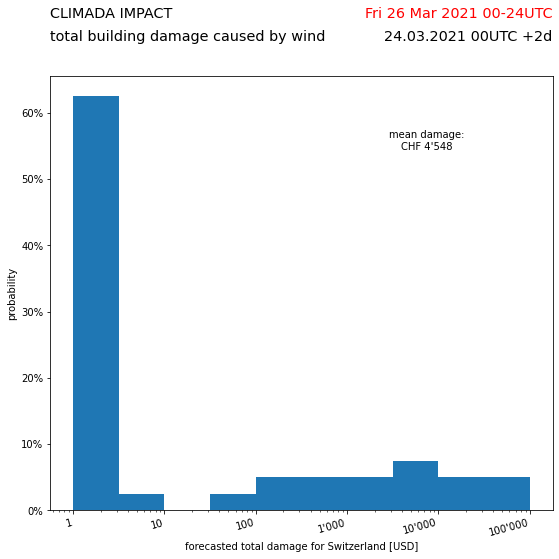

In [3]:
CH_WS_forecast.plot_hist(save_fig=False,close_fig=False)

It is possible to color the pixels depending on the probability that a certain threshold of impact is reach at a certain grid point

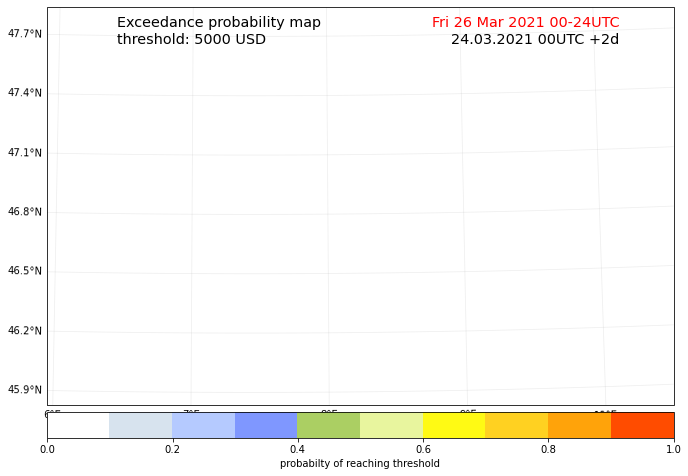

In [4]:
CH_WS_forecast.plot_exceedence_prob(threshold=5000, save_fig=False, close_fig=False)

It is possible to color the cantons of Switzerland with warning colors, based on aggregated forecasted impacts in their area.

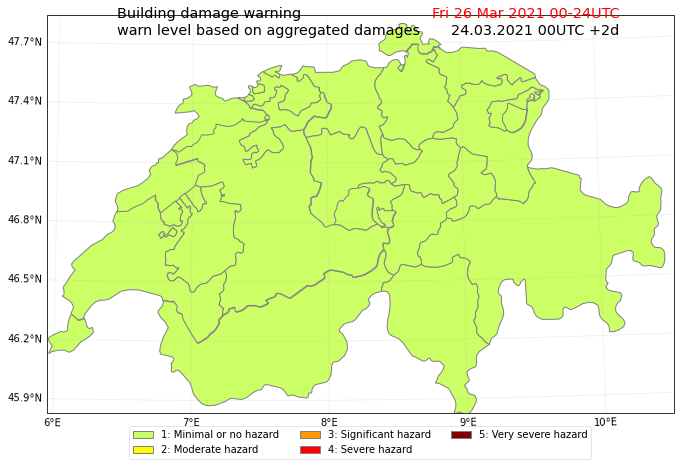

In [5]:
import fiona
from cartopy.io import shapereader
from climada.util.config import CONFIG


#create a file containing the polygons of Swiss cantons using natural earth
cantons_file = CONFIG.local_data.save_dir.dir() / 'cantons.shp'
adm1_shape_file = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')
if not cantons_file.exists():
    with fiona.open(adm1_shape_file, 'r') as source:
        with fiona.open(
                cantons_file, 'w',
                **source.meta) as sink:

            for f in source:
                if f['properties']['adm0_a3'] == 'CHE':
                    sink.write(f)
CH_WS_forecast.plot_warn_map(str(cantons_file),
                           decision_level = 'polygon',
                           thresholds=[100000,500000,
                                      1000000,5000000],
                           probability_aggregation='mean',
                           area_aggregation='sum',
                           title="Building damage warning",
                           explain_text="warn level based on aggregated damages",
                           save_fig=False,
                           close_fig=False)

## Example 2: forecast of wind warnings in Switzerland
Instead of a fully fledged socio-economic impact of storms, one can also simplify the hazard, exposure, vulnerability model, by looking at a "neutral" exposure (=1 at every gridpoint) and using a step function as impact function to arrive at warn levels. It also shows how the attributes hazard, exposure or vulnerability can be set before calling calc(), and are then considered in the forecast instead of the defined defaults.

In [6]:
from pandas import DataFrame
import numpy as np
from climada.entity.exposures import Exposures
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

### generate exposure
# Fill DataFrame with values for a "neutral" exposure (value = 1)
exp_df = DataFrame()
exp_df['value'] = np.ones_like(hazard.centroids.lat) # provide value
exp_df['latitude'] = hazard.centroids.lat
exp_df['longitude'] = hazard.centroids.lon
exp_df['if_WS'] = np.ones_like(hazard.centroids.lat, int)
# Generate Exposures
exp = Exposures(exp_df)
exp.check()
exp.value_unit = 'warn_level'

### generate impact functions
## impact functions for hazard based warnings
imp_fun_low = ImpactFunc() 
imp_fun_low.haz_type = 'WS'
imp_fun_low.id = 1
imp_fun_low.name = 'warn_level_low_elevation'
imp_fun_low.intensity_unit = 'm/s'
imp_fun_low.intensity = np.array([0.0, 19.439, 
                                  19.44, 24.999, 
                                  25.0, 30.549, 
                                  30.55, 38.879, 
                                  38.88, 100.0])
imp_fun_low.mdd = np.array([1.0, 1.0, 
                            2.0, 2.0, 
                            3.0, 3.0, 
                            4.0, 4.0, 
                            5.0, 5.0])
imp_fun_low.paa = np.ones_like(imp_fun_low.mdd)
imp_fun_low.check()
# fill ImpactFuncSet
impf_set = ImpactFuncSet()
impf_set.append(imp_fun_low)

2021-03-24 17:54:46,074 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-24 17:54:46,075 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-24 17:54:46,077 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-24 17:54:46,077 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-24 17:54:46,078 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-24 17:54:46,079 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-24 17:54:46,094 - climada.entity.exposures.base - INFO - cover not set.
2021-03-24 17:54:46,094 - climada.entity.exposures.base - INFO - deductible not set.
2021-03-24 17:54:46,094 - climada.entity.exposures.base - INFO - geometry not set.
2021-03-24 17:54:46,094 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-24 17:54:46,094 - climada.entity.exposures.base - INFO - centr_ n

C:\shortpaths\GitHub\climada_python\climada\entity\exposures\base.py:219: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


In [7]:
from datetime import datetime
#generate hazard with four days leadtime
hazard, haz_model, run_datetime, event_date = generate_WS_forecast_hazard(
    run_datetime=datetime(2021,3,7), #specify run_datetime (works only if the files have already been downloaded)
    event_date=datetime(2021,3,11)) 
#create and calculate Forecast
warn_forecast = Forecast({run_datetime: hazard}, exp, impf_set)
warn_forecast.calc()

2021-03-24 17:54:46,110 - climada.hazard.storm_europe - INFO - Generating IEE hazard.
2021-03-24 17:54:46,110 - climada.util.dwd_icon_loader - INFO - Downloading icon grib files of model icon-eu-eps for parameter vmax_10m with starting date 2021030700.
2021-03-24 17:54:46,126 - climada.hazard.storm_europe - INFO - Constructing centroids from C:\Users\ThomasRoosli\climada\data\results\icon_grid_0028_R02B07_N02.nc
2021-03-24 17:54:46,188 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


C:\shortpaths\GitHub\climada_python\climada\hazard\centroids\centr.py:624: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'
ecCodes provides no lat

2021-03-24 17:55:55,927 - climada.entity.exposures.base - INFO - Matching 75948 exposures with 75948 centroids.
2021-03-24 17:55:55,935 - climada.engine.impact - INFO - Calculating damage for 75948 assets (>0) and 40 events.


The each grid point now has a warnlevel between 1-5 assigned for each event. Now the  cantons can be colored based on a threshold on a grid point level. for each warning level it is assessed if 50% of grid points in the area of a canton has at least a 50% probability of reaching the specified threshold.

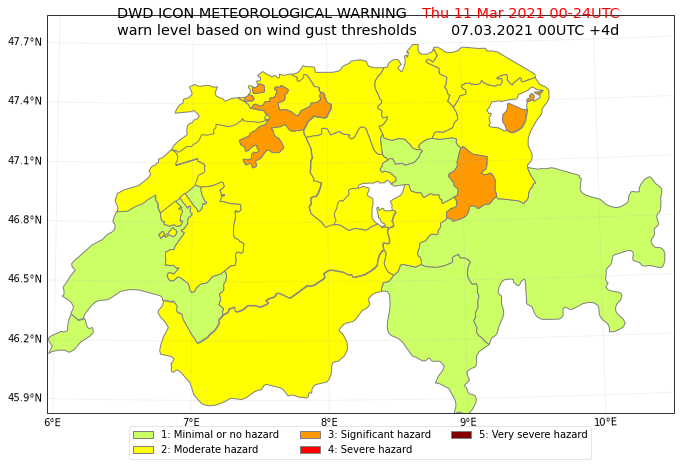

In [8]:
warn_forecast.plot_warn_map(cantons_file,
                           thresholds=[2,3,4,5],
                           decision_level = 'exposure_point',
                           probability_aggregation=0.5,
                           area_aggregation=0.5,
                           title="DWD ICON METEOROLOGICAL WARNING",
                           explain_text="warn level based on wind gust thresholds",
                           save_fig=False,
                           close_fig=False)

## Example: Tropical Cylcone
It would be nice to add an example using the tropical cyclone forecasts from the class TCForecast. This has not yet been done.